In [1]:
## Import Statements

In [2]:
import os
import pandas as pd
import numpy as np
import csv
import folium
import geopandas as gpd
import seaborn as sb
import sklearn.model_selection as skl_ms
import sklearn.linear_model as skl_lm
import sklearn.metrics as metr

from matplotlib import pyplot as plt

try:
    from osgeo import gdal
    from osgeo import ogr

except ImportError:
    import gdal
    import ogr

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
## Defining Data Path and Loading Cal Fire Suppression Expenditures Data
## Data sourced from CalFire

In [5]:
dir_path = os.getcwd()
expenditures_path = os.path.join(dir_path, "Data", "CA_Fire_Expenditures.csv")

expenditures_df = pd.read_csv(expenditures_path, index_col=["Fiscal Year"], header=0,
                               names=['Fiscal Year', 'Expenditure(in $)'])

expenditures_df.head(3)

,Expenditure(in $)
Fiscal Year,
1979,11978000
1980,21178000
1981,12582000


In [6]:
## Function for Creating Fire Suppression Expenditures Bar Plot

In [7]:
def expenditure_plot(df, save_path):
    fig, ax = plt.subplots(figsize=(10, 6))
    expenditures_df.plot(ax=ax, kind='bar')
    plt.grid(color='grey', linestyle=':', linewidth=0.5)
    plt.title('California Fire Suppression Expenditures')
    plt.ylabel('Fire Suppression Expenditure in Billion $')
    plt.xlabel('Fiscal Year')
    plt.setp(ax.get_xticklabels(), rotation=60)
    plt.savefig(save_path)
    return plt

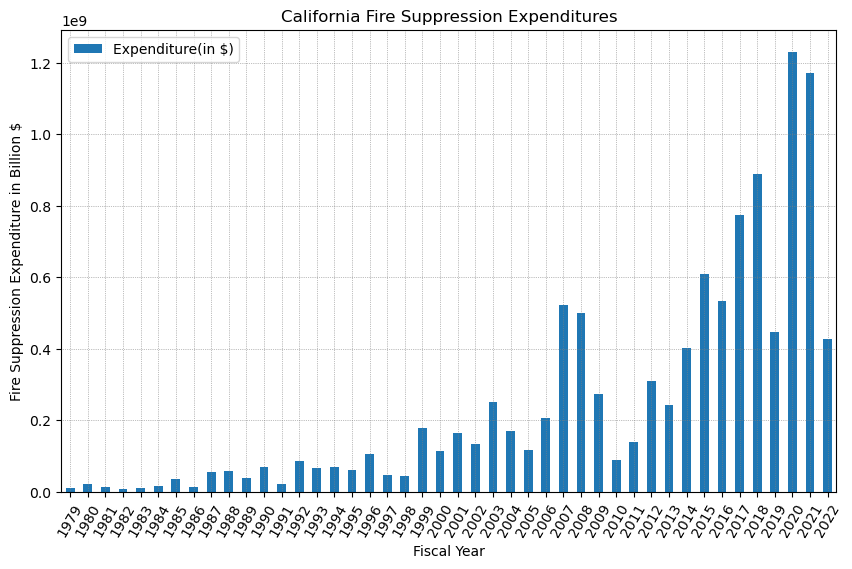

In [8]:
ep_plt = expenditure_plot(expenditures_df, os.path.join(dir_path, "Plots", "Expenditures_bar.png"))
ep_plt.show()

In [9]:
## Loading California Historical Fires Data downloades from ESRI ArcGIS Shapefiles

In [10]:
BurnArea_path_2020 = os.path.join(dir_path, "Data", "California_Fire_Perimeters_2020", "Burn_areas.shp")
BurnArea_path_2021 = os.path.join(dir_path, "Data", "California_Fire_Perimeters_2021", "Burn_areas.shp")

In [11]:
## Function to read shapefile and gather Valley fire details into csv and dict

In [12]:
def burn_areas_to_csv_dict(driver_name, file_path, out_file_path, fires_list, agency_name):
    """
    :param driver_name: ogr driver required to read the file
    :param file_path: input data path
    :param output_file_path: output csv path
    :param fires_list: list of fires for which info is being collected
    :param agency_name: agency from where the info is needed for the fire
    :return: Dictionary with fire info
    """
    # Get the ESRI Shapefile driver
    driver = ogr.GetDriverByName(driver_name)
    
    out_dict = dict()

    # Open the data source in read mode
    read_data_source = driver.Open(file_path, update=0)

    # Get Data layer
    layer = read_data_source.GetLayer()
    
    feature_count = layer.GetFeatureCount()
    
    f = open(out_file_path, 'w')
    writer = csv.writer(f)
    header_row = ["fire_name", "year", "alarm_date", "containment_date", "report_acreage", "gis_acreage", "geometry"]
    writer.writerow(header_row)
    
    for i in range(feature_count):
        feature = layer.GetFeature(i)
        fires = feature.GetField(4)
        Agency = feature.GetField(2)
        if Agency == agency_name:
            if fires in fires_list:
                year = feature.GetField(0)
                alarm_date = feature.GetField(6)
                containment_date = feature.GetField(7)
                report_acreage = feature.GetField(10)
                GIS_acreage = feature.GetField(11)
                geom = feature.GetGeometryRef()
                writer.writerow([fires, year, alarm_date, containment_date, report_acreage, GIS_acreage, geom])
                out_dict = {"fire":fires, "year":year, "alarm_date":alarm_date, "containment_date":containment_date,
                            "report_acreage":report_acreage, "GIS_acreage":GIS_acreage, "geometry":geom}
        feature.Destroy()
    
    f.close()
    # Destroy Data Source
    read_data_source.Destroy()
    return out_dict

In [13]:
### Output Paths to save Fire details as csv and Run the above function

In [14]:
fires_list = ['VALLEY', 'SOUTHERN']
output_path_2020 = os.path.join(dir_path, "Data", "Fire_2020.csv")
output_path_2021 = os.path.join(dir_path, "Data", "Fire_2021.csv")

Valley_2020 = burn_areas_to_csv_dict('ESRI Shapefile', BurnArea_path_2020, output_path_2020, fires_list, 'USF')
Southern_2021 = burn_areas_to_csv_dict('ESRI Shapefile', BurnArea_path_2021, output_path_2021, fires_list, 'CDF')

In [15]:
Valley_2020

{'fire': 'VALLEY',
 'year': '2020',
 'alarm_date': '2020/09/05',
 'containment_date': '2020/09/24',
 'report_acreage': 16390.0,
 'GIS_acreage': 16389.5,
 'geometry': <osgeo.ogr.Geometry; proxy of <Swig Object of type 'OGRGeometryShadow *' at 0x7fbff40da750> >}

In [16]:
Southern_2021

{'fire': 'SOUTHERN',
 'year': '2021',
 'alarm_date': '2021/05/02',
 'containment_date': '2022/05/06',
 'report_acreage': 5365.0,
 'GIS_acreage': 5365.9,
 'geometry': <osgeo.ogr.Geometry; proxy of <Swig Object of type 'OGRGeometryShadow *' at 0x7fc011066d20> >}

In [17]:
## File Path to Chemical Compositions of Air Pollutants data for the year 2020 (Valley Wildfire Year)
## Files downloaded from EPA Website

In [18]:
Ozone_2020_path = os.path.join(dir_path, "Data", "Daily_data_2020", "Ozone_data_2020.csv")

CO_2020_path = os.path.join(dir_path, "Data", "Daily_data_2020", "CO_data_2020.csv")

NO2_2020_path = os.path.join(dir_path, "Data", "Daily_data_2020", "NO2_data_2020.csv")

SO2_2020_path = os.path.join(dir_path, "Data", "Daily_data_2020", "SO2_data_2020.csv")

Lead_2020_path = os.path.join(dir_path, "Data", "Daily_data_2020", "Lead_data_2020.csv")

PM2_5_2020_path = os.path.join(dir_path, "Data", "Daily_data_2020", "PM2.5_data_2020.csv")

PM10_2020_path = os.path.join(dir_path, "Data", "Daily_data_2020", "PM10_data_2020.csv")

In [19]:
## Data Frames loaded from the above files with only required columns

In [20]:
sd_ozone_2020_df = pd.read_csv(Ozone_2020_path, parse_dates=['Date'], index_col=['Date'], usecols=['Date', 'Daily Max 8-hour Ozone Concentration', 
        'Site Name', 'STATE', 'COUNTY'])

sd_CO_2020_df = pd.read_csv(CO_2020_path, parse_dates=['Date'], index_col=['Date'], usecols=['Date', 'Daily Max 8-hour CO Concentration', 
        'Site Name', 'STATE', 'COUNTY'])

sd_NO2_2020_df = pd.read_csv(NO2_2020_path, parse_dates=['Date'], index_col=['Date'], usecols=['Date', 'Daily Max 1-hour NO2 Concentration', 
        'Site Name', 'STATE', 'COUNTY'])

sd_SO2_2020_df = pd.read_csv(SO2_2020_path, parse_dates=['Date'], index_col=['Date'], usecols=['Date', 'Daily Max 1-hour SO2 Concentration', 
        'Site Name', 'STATE', 'COUNTY'])

sd_Lead_2020_df = pd.read_csv(Lead_2020_path, parse_dates=['Date'], index_col=['Date'], usecols=['Date', 'Daily Mean Pb Concentration', 
        'Site Name', 'STATE', 'COUNTY'])

sd_PM2_5_2020_df = pd.read_csv(PM2_5_2020_path, parse_dates=['Date'], index_col=['Date'], usecols=['Date', 'Daily Mean PM2.5 Concentration', 
        'Site Name', 'STATE', 'COUNTY'])

sd_PM10_2020_df = pd.read_csv(PM10_2020_path, parse_dates=['Date'], index_col=['Date'], usecols=['Date', 'Daily Mean PM10 Concentration', 
        'Site Name', 'STATE', 'COUNTY'])

In [21]:
## Averaging the measured daily data collected across different measuring stations in San Diego County by Date

In [22]:
sd_mean_ozone_2020_df = pd.DataFrame(sd_ozone_2020_df.groupby('Date').mean())
sd_mean_ozone_2020_df.columns = ['Arithmetic mean']
sd_mean_ozone_2020_df.head(3)

,Arithmetic mean
Date,
2020-01-01,0.039125
2020-01-02,0.035000
2020-01-03,0.035750


In [23]:
sd_mean_CO_2020_df = pd.DataFrame(sd_CO_2020_df.groupby('Date').mean())
sd_mean_CO_2020_df.columns = ['Arithmetic mean']
sd_mean_CO_2020_df.head(3)

,Arithmetic mean
Date,
2020-01-01,0.85
2020-01-02,0.95
2020-01-03,1.20


In [24]:
sd_mean_NO2_2020_df = pd.DataFrame(sd_NO2_2020_df.groupby('Date').mean())
sd_mean_NO2_2020_df.columns = ['Arithmetic mean']
sd_mean_NO2_2020_df.head(3)

,Arithmetic mean
Date,
2020-01-01,16.375
2020-01-02,26.125
2020-01-03,30.000


In [25]:
sd_mean_SO2_2020_df = pd.DataFrame(sd_SO2_2020_df.groupby('Date').mean())
sd_mean_SO2_2020_df.columns = ['Arithmetic mean']
sd_mean_SO2_2020_df.head(3)

,Arithmetic mean
Date,
2020-01-01,0.4
2020-01-02,0.2
2020-01-03,0.3


In [26]:
sd_mean_Lead_2020_df = pd.DataFrame(sd_Lead_2020_df.groupby('Date').mean())
sd_mean_Lead_2020_df.columns = ['Arithmetic mean']
sd_mean_Lead_2020_df.head(3)

,Arithmetic mean
Date,
2020-01-04,0.012268
2020-01-09,0.013000
2020-01-16,0.030745


In [27]:
sd_mean_PM2_5_2020_df = pd.DataFrame(sd_PM2_5_2020_df.groupby('Date').mean())
sd_mean_PM2_5_2020_df.columns = ['Arithmetic mean']
sd_mean_PM2_5_2020_df.head(3)

,Arithmetic mean
Date,
2020-01-01,9.466667
2020-01-02,11.500000
2020-01-03,10.583333


In [28]:
sd_mean_PM10_2020_df = pd.DataFrame(sd_PM10_2020_df.groupby('Date').mean())
sd_mean_PM10_2020_df.columns = ['Arithmetic mean']
sd_mean_PM10_2020_df.head(3)

,Arithmetic mean
Date,
2020-01-01,30.00
2020-01-04,30.25
2020-01-07,21.00


In [29]:
## Time Series plot of the Chemical Composition of Air Pollutants in Year 2020 in San Diego County

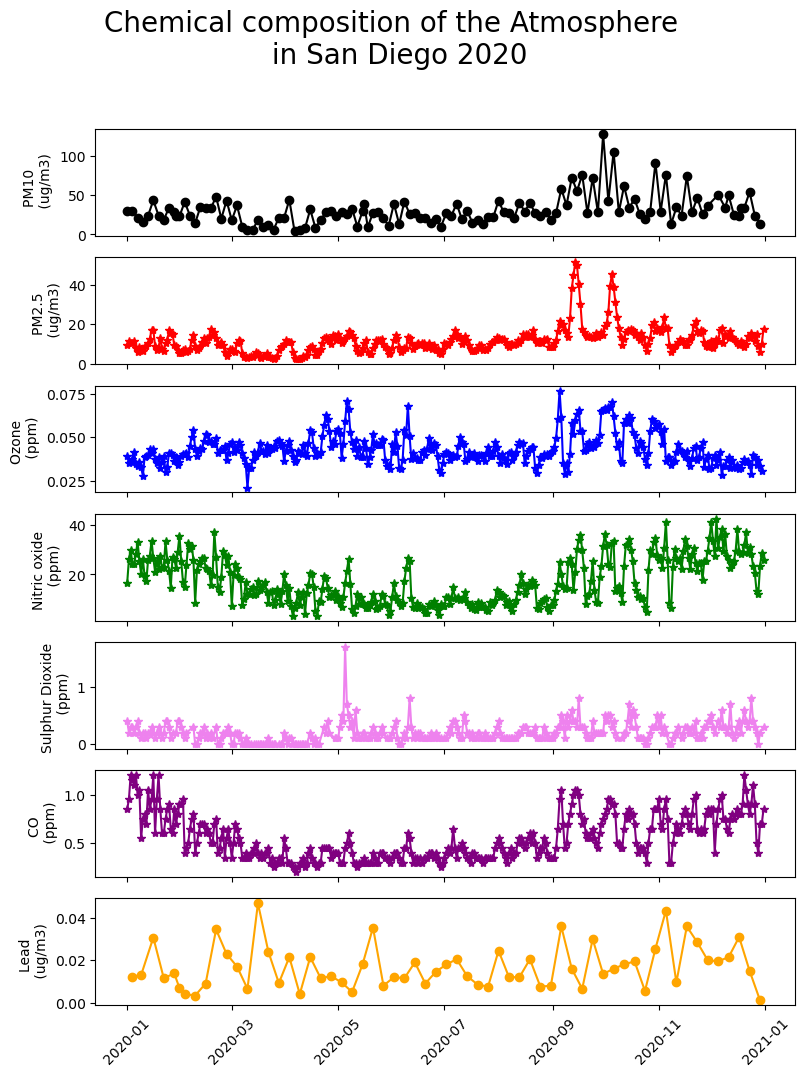

In [30]:
# Create plot space
fig, (ax1, ax2, ax3,ax4, ax5, ax6, ax7) = plt.subplots(7,1, sharex = True, figsize = (10, 12))

# Add subtitle 
fig.subplots_adjust(bottom=0.15, left=0.2)
fig.suptitle("""Chemical composition of the Atmosphere \n in San Diego 2020""", fontsize = 20)


# Select plot type and add x and y-axis values to the plot
ax1.plot(sd_mean_PM10_2020_df.index.values,
       sd_mean_PM10_2020_df['Arithmetic mean'], 
       color = "black",
       marker = "o")

ax2.plot(sd_mean_PM2_5_2020_df.index.values,
       sd_mean_PM2_5_2020_df['Arithmetic mean'], 
       color = "red",
       marker = "*")

ax3.plot(sd_mean_ozone_2020_df.index.values,
       sd_mean_ozone_2020_df['Arithmetic mean'], 
       color = "blue",
       marker = "*")

ax4.plot(sd_mean_NO2_2020_df.index.values,
       sd_mean_NO2_2020_df['Arithmetic mean'], 
       color = "green",
       marker = "*")

ax5.plot(sd_mean_SO2_2020_df.index.values,
       sd_mean_SO2_2020_df['Arithmetic mean'], 
       color = "violet",
       marker = "*")

ax6.plot(sd_mean_CO_2020_df.index.values,
       sd_mean_CO_2020_df['Arithmetic mean'], 
       color = "purple",
       marker = "*")

ax7.plot(sd_mean_Lead_2020_df.index.values,
       sd_mean_Lead_2020_df['Arithmetic mean'], 
       color = "orange",
       marker = "o")


ax1.set(ylabel= "PM10  \n (ug/m3)")

ax2.set(ylabel="PM2.5 \n (ug/m3)")

ax3.set(ylabel="Ozone \n (ppm)")

ax4.set(ylabel="Nitric oxide \n (ppm)")

ax5.set(ylabel="Sulphur Dioxide \n (ppm)")

ax6.set(ylabel="CO \n (ppm)")

ax7.set(ylabel="Lead \n (ug/m3)")

plt.setp(ax7.get_xticklabels(), rotation=45)

plt.savefig(os.path.join(dir_path, "Plots", "chemical composition.png"))

plt.show()



In [31]:
## File Paths to Weather data for the year 2020 (Valley Wildfire Year)
## Files downloaded from EPA Website

In [32]:
Temp_2020_path = os.path.join(dir_path, "Data", "Daily_data_2020", "TEMP_data_2020.csv")

Pressure_2020_path = os.path.join(dir_path, "Data", "Daily_data_2020", "Pressure_data_2020.csv")

Wind_2020_path = os.path.join(dir_path, "Data", "Daily_data_2020", "WIND_data_2020.csv")

VOCS_2020_path = os.path.join(dir_path, "Data", "Daily_data_2020", "VOCS_data_2020.csv")

RH_DP_2020_path = os.path.join(dir_path, "Data", "Daily_data_2020", "RH_DP_data_2020.csv")

HAPS_2020_path = os.path.join(dir_path, "Data", "Daily_data_2020", "HAPS_data_2020.csv")

NONOxNOy_2020_path = os.path.join(dir_path, "Data", "Daily_data_2020", "NONOxNOy_data_2020.csv")

In [33]:
## Data Frames loaded from the above files with only required columns
## Averaging the measured daily data collected across different measuring stations in San Diego County by Date

In [34]:
sd_Temp_2020_df = pd.read_csv(Temp_2020_path, parse_dates=['Date Local'], index_col=['Date Local'], usecols=['Date Local', 'Arithmetic Mean', 
        'Local Site Name', 'State Name', 'County Name'])
sd_mean_Temp_2020_df = pd.DataFrame(sd_Temp_2020_df[sd_Temp_2020_df['County Name']=='San Diego'].groupby('Date Local').mean())
sd_mean_Temp_2020_df.head(3)

,Arithmetic Mean
Date Local,
2020-01-01,55.010417
2020-01-02,55.739583
2020-01-03,58.432292


In [35]:
sd_Pressure_2020_df = pd.read_csv(Pressure_2020_path, parse_dates=['Date Local'], index_col=['Date Local'], usecols=['Date Local', 'Arithmetic Mean', 
        'Local Site Name', 'State Name', 'County Name'])

sd_mean_Pressure_2020_df = pd.DataFrame(sd_Pressure_2020_df[sd_Pressure_2020_df['County Name']=='San Diego'].groupby('Date Local').mean())
sd_mean_Pressure_2020_df.head(3)

,Arithmetic Mean
Date Local,
2020-01-01,999.366667
2020-01-02,998.202084
2020-01-03,1006.404166


In [36]:
sd_Wind_2020_df = pd.read_csv(Wind_2020_path, parse_dates=['Date Local'], index_col=['Date Local'], usecols=['Date Local', 'Arithmetic Mean', 
        'Local Site Name', 'State Name', 'County Name'])

sd_mean_Wind_2020_df = pd.DataFrame(sd_Wind_2020_df[sd_Wind_2020_df['County Name']=='San Diego'].groupby('Date Local').mean())
sd_mean_Wind_2020_df.head(3)

,Arithmetic Mean
Date Local,
2020-01-01,73.790178
2020-01-02,74.382738
2020-01-03,74.570380


In [37]:
sd_VOCS_2020_df = pd.read_csv(VOCS_2020_path, parse_dates=['Date Local'], index_col=['Date Local'], usecols=['Date Local', 'Arithmetic Mean', 
        'Local Site Name', 'State Name', 'County Name'])

sd_mean_VOCS_2020_df = pd.DataFrame(sd_VOCS_2020_df[sd_VOCS_2020_df['County Name']=='San Diego'].groupby('Date Local').mean())
sd_mean_VOCS_2020_df.head(3)

,Arithmetic Mean
Date Local,
2020-01-04,0.641249
2020-01-10,0.310573
2020-01-16,0.681325


In [38]:
sd_RH_DP_2020_df = pd.read_csv(RH_DP_2020_path, parse_dates=['Date Local'], index_col=['Date Local'], usecols=['Date Local', 'Arithmetic Mean', 
        'Local Site Name', 'State Name', 'County Name'])

sd_mean_RH_DP_2020_df = pd.DataFrame(sd_RH_DP_2020_df[sd_RH_DP_2020_df['County Name']=='San Diego'].groupby('Date Local').mean())
sd_mean_RH_DP_2020_df.head(3)

,Arithmetic Mean
Date Local,
2020-01-01,62.736111
2020-01-02,66.652778
2020-01-03,49.111111


In [39]:
sd_HAPS_2020_df = pd.read_csv(HAPS_2020_path, parse_dates=['Date Local'], index_col=['Date Local'], usecols=['Date Local', 'Arithmetic Mean', 
        'Local Site Name', 'State Name', 'County Name'])

sd_mean_HAPS_2020_df = pd.DataFrame(sd_HAPS_2020_df[sd_HAPS_2020_df['County Name']=='San Diego'].groupby('Date Local').mean())
sd_mean_HAPS_2020_df.head(3)

,Arithmetic Mean
Date Local,
2020-01-01,0.001000
2020-01-04,0.356209
2020-01-07,0.001000


In [40]:
sd_NONOxNOy_2020_df = pd.read_csv(NONOxNOy_2020_path, parse_dates=['Date Local'], index_col=['Date Local'], usecols=['Date Local', 'Arithmetic Mean', 
        'Local Site Name', 'State Name', 'County Name'])

sd_mean_NONOxNOy_2020_df = pd.DataFrame(sd_NONOxNOy_2020_df[sd_NONOxNOy_2020_df['County Name']=='San Diego'].groupby('Date Local').mean())
sd_mean_NONOxNOy_2020_df.head(3)

,Arithmetic Mean
Date Local,
2020-01-01,5.967989
2020-01-02,10.269336
2020-01-03,15.748100


In [41]:
## Time Series plot of the Chemical Composition of Air Pollutants in Year 2020 in San Diego County

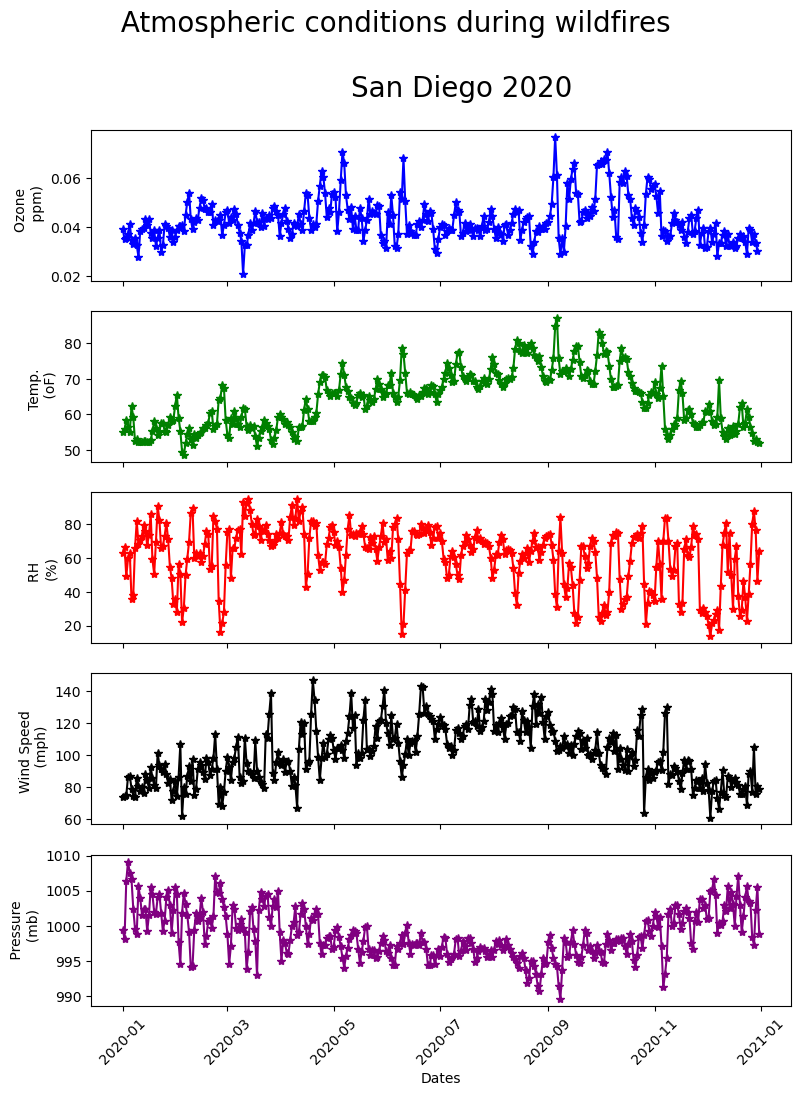

In [42]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, sharex = True, figsize = (10, 12))

fig.subplots_adjust(bottom=0.15, left=0.2)
fig.suptitle(""" Atmospheric conditions during wildfires\n
                San Diego 2020""", fontsize = 20)

# Select plot type and add x and y-axis values to the plot.
ax1.plot(sd_mean_ozone_2020_df.index.values,
       sd_mean_ozone_2020_df['Arithmetic mean'], 
       color = "blue",
       marker = "*")
ax2.plot(sd_mean_Temp_2020_df.index.values,
       sd_mean_Temp_2020_df['Arithmetic Mean'], 
       color = "green",
       marker = "*")
ax3.plot(sd_mean_RH_DP_2020_df.index.values,
       sd_mean_RH_DP_2020_df['Arithmetic Mean'], 
       color = "red",
       marker = "*")
ax4.plot(sd_mean_Wind_2020_df.index.values,
       sd_mean_Wind_2020_df['Arithmetic Mean'], 
       color = "black",
       marker = "*")
ax5.plot(sd_mean_Pressure_2020_df.index.values,
       sd_mean_Pressure_2020_df['Arithmetic Mean'], 
       color = "purple",
       marker = "*")

ax1.set(ylabel="Ozone  \n ppm)")

ax2.set(ylabel="Temp. \n (oF)")

ax3.set(ylabel="RH  \n(%)")

ax4.set(ylabel="Wind Speed \n (mph)")

ax5.set(xlabel="Dates", 
       ylabel=" Pressure \n  (mb)")

plt.setp(ax5.get_xticklabels(), rotation=45)

plt.savefig(os.path.join(dir_path, "Plots", "Atmospheric Conditions.png"))

plt.show()

In [43]:
## Merging the Data frames to form Three different dataframes
## First with Chemical Composition of Air Pollutants Data
## Second with Weather Data
### Third with Combined Data

In [44]:
## Merging Ozone and CO Data frames

In [45]:
sd_mean_chemical_composition_df = pd.merge(sd_mean_ozone_2020_df, sd_mean_CO_2020_df, left_index=True, right_index=True)
sd_mean_chemical_composition_df.head(3)

,Arithmetic mean_x,Arithmetic mean_y
Date,,
2020-01-01,0.039125,0.85
2020-01-02,0.035000,0.95
2020-01-03,0.035750,1.20


In [46]:
## Checking column names after merging

In [47]:
sd_mean_chemical_composition_df.columns

Index(['Arithmetic mean_x', 'Arithmetic mean_y'], dtype='object')

In [48]:
## Renaming Column names as required

In [49]:
sd_mean_chemical_composition_df.rename(columns = {'Arithmetic mean_x': 'Ozone Mean', 'Arithmetic mean_y': 'CO Mean'}, inplace = True)
sd_mean_chemical_composition_df.head(3)

,Ozone Mean,CO Mean
Date,,
2020-01-01,0.039125,0.85
2020-01-02,0.035000,0.95
2020-01-03,0.035750,1.20


In [50]:
sd_mean_chemical_composition_df = pd.merge(sd_mean_chemical_composition_df, sd_mean_NO2_2020_df, left_index=True, right_index=True)
sd_mean_chemical_composition_df.rename(columns = {'Arithmetic mean': 'NO2 Mean'}, inplace = True)
sd_mean_chemical_composition_df.head(3)

,Ozone Mean,CO Mean,NO2 Mean
Date,,,
2020-01-01,0.039125,0.85,16.375
2020-01-02,0.035000,0.95,26.125
2020-01-03,0.035750,1.20,30.000


In [51]:
sd_mean_chemical_composition_df = pd.merge(sd_mean_chemical_composition_df, sd_mean_PM2_5_2020_df, left_index=True, right_index=True)
sd_mean_chemical_composition_df.rename(columns = {'Arithmetic mean': 'PM2.5 Mean'}, inplace = True)
sd_mean_chemical_composition_df.head(3)

,Ozone Mean,CO Mean,NO2 Mean,PM2.5 Mean
Date,,,,
2020-01-01,0.039125,0.85,16.375,9.466667
2020-01-02,0.035000,0.95,26.125,11.500000
2020-01-03,0.035750,1.20,30.000,10.583333


In [52]:
sd_mean_weather_df = pd.merge(sd_mean_Temp_2020_df, sd_mean_Pressure_2020_df, left_index=True, right_index=True)
sd_mean_weather_df.head(3)

,Arithmetic Mean_x,Arithmetic Mean_y
Date Local,,
2020-01-01,55.010417,999.366667
2020-01-02,55.739583,998.202084
2020-01-03,58.432292,1006.404166


In [53]:
sd_mean_weather_df.columns

Index(['Arithmetic Mean_x', 'Arithmetic Mean_y'], dtype='object')

In [54]:
sd_mean_weather_df.rename(columns = {'Arithmetic Mean_x': 'Temp Mean', 'Arithmetic Mean_y': 'Pressure Mean'}, inplace = True)
sd_mean_weather_df.head(3)

,Temp Mean,Pressure Mean
Date Local,,
2020-01-01,55.010417,999.366667
2020-01-02,55.739583,998.202084
2020-01-03,58.432292,1006.404166


In [55]:
sd_mean_weather_df = pd.merge(sd_mean_weather_df, sd_mean_Wind_2020_df, left_index=True, right_index=True)
sd_mean_weather_df.rename(columns = {'Arithmetic Mean': 'Wind Mean'}, inplace = True)
sd_mean_weather_df.head(3)

,Temp Mean,Pressure Mean,Wind Mean
Date Local,,,
2020-01-01,55.010417,999.366667,73.790178
2020-01-02,55.739583,998.202084,74.382738
2020-01-03,58.432292,1006.404166,74.570380


In [56]:
sd_mean_weather_df = pd.merge(sd_mean_weather_df, sd_mean_RH_DP_2020_df, left_index=True, right_index=True)
sd_mean_weather_df.rename(columns = {'Arithmetic Mean': 'RH Mean'}, inplace = True)
sd_mean_weather_df.head(3)

,Temp Mean,Pressure Mean,Wind Mean,RH Mean
Date Local,,,,
2020-01-01,55.010417,999.366667,73.790178,62.736111
2020-01-02,55.739583,998.202084,74.382738,66.652778
2020-01-03,58.432292,1006.404166,74.570380,49.111111


In [57]:
sd_combined_df = pd.merge(sd_mean_chemical_composition_df, sd_mean_weather_df, left_index=True, right_index=True)
sd_combined_df.head(3)

,Ozone Mean,CO Mean,NO2 Mean,PM2.5 Mean,Temp Mean,Pressure Mean,Wind Mean,RH Mean
2020-01-01,0.039125,0.85,16.375,9.466667,55.010417,999.366667,73.790178,62.736111
2020-01-02,0.035000,0.95,26.125,11.500000,55.739583,998.202084,74.382738,66.652778
2020-01-03,0.035750,1.20,30.000,10.583333,58.432292,1006.404166,74.570380,49.111111


In [58]:
## Scatter Plot Mattrix of Weather Pattern

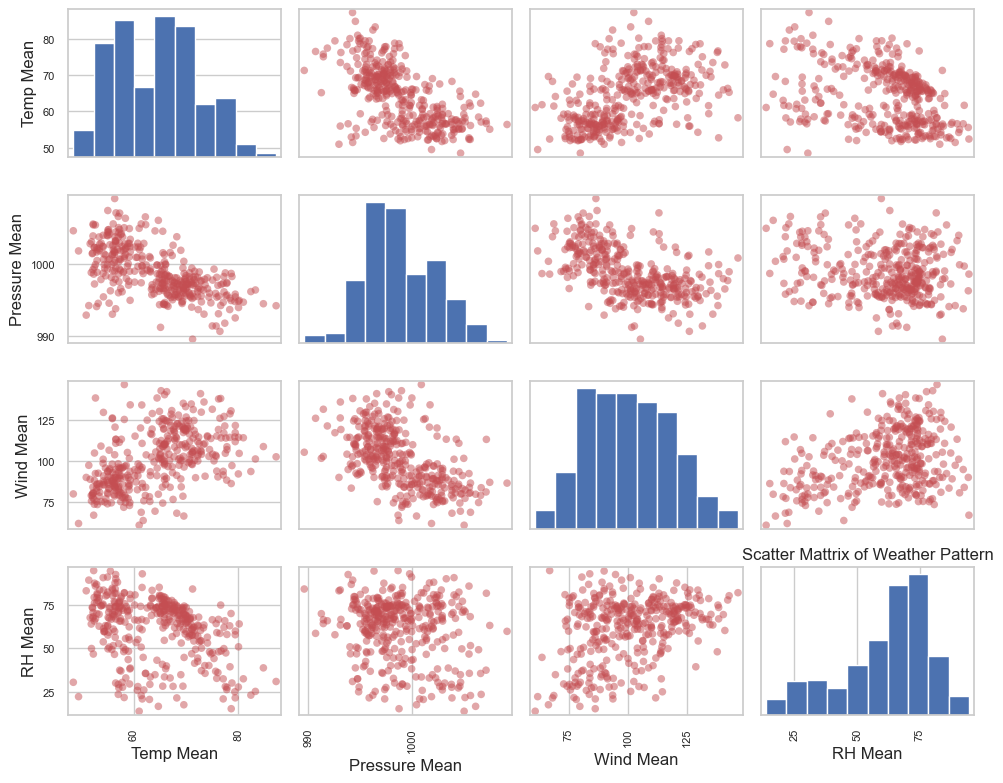

In [59]:
sb.set(font_scale=1, style="whitegrid")
pd.plotting.scatter_matrix(sd_mean_weather_df, s=30, figsize=[10, 8], marker='o', color='r')

plt.title('Scatter Mattrix of Weather Pattern')
plt.tight_layout()
plt.savefig(os.path.join(dir_path, "Plots", "Weather Scatter.png"))

plt.show()

In [60]:
## Data frame created as a subset of combined dataframe to study Weather relation to Ozone Formation

In [61]:
sd_weather_with_ozone_df = sd_combined_df[['Ozone Mean', 'Temp Mean', 'Pressure Mean', 'RH Mean']]
sd_weather_with_ozone_df.head(3)

,Ozone Mean,Temp Mean,Pressure Mean,RH Mean
2020-01-01,0.039125,55.010417,999.366667,62.736111
2020-01-02,0.035000,55.739583,998.202084,66.652778
2020-01-03,0.035750,58.432292,1006.404166,49.111111


In [62]:
## Scatter Plot Mattrix of Weather with Ozone

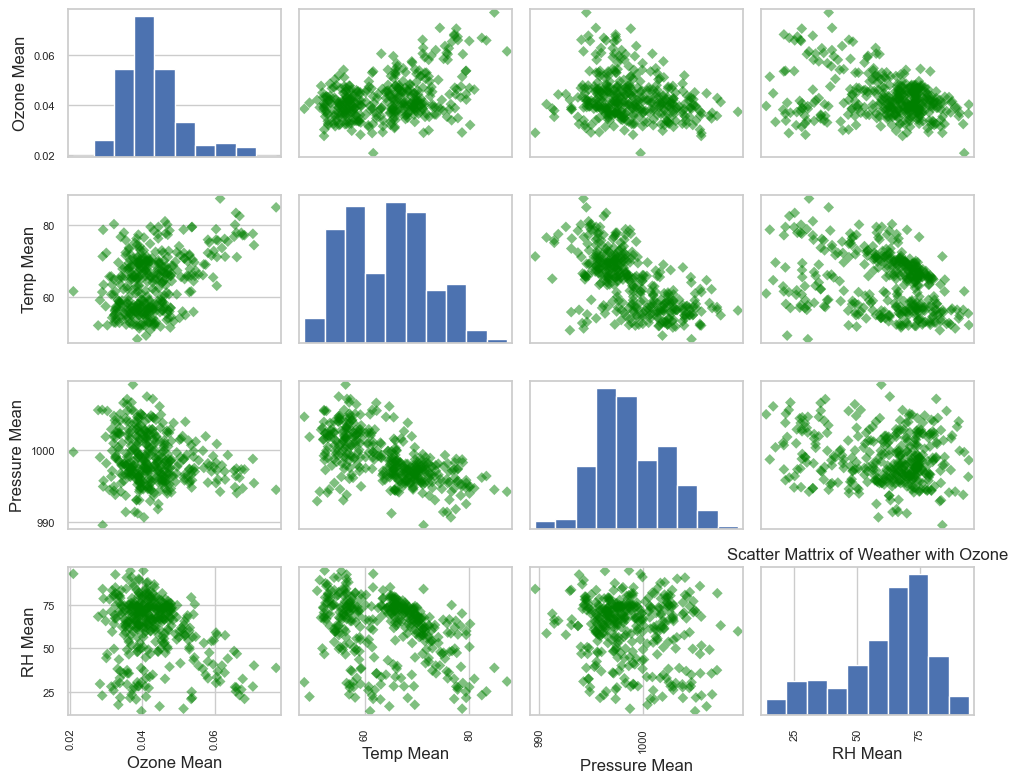

In [63]:
pd.plotting.scatter_matrix(sd_weather_with_ozone_df, s=30, figsize = [10, 8], marker='D', color = 'green')

plt.title('Scatter Mattrix of Weather with Ozone')
plt.tight_layout()
plt.savefig(os.path.join(dir_path, "Plots", "Weather Ozone Scatter.png"))
plt.show()

In [64]:
sd_mean_chemical_composition_df.columns

Index(['Ozone Mean', 'CO Mean', 'NO2 Mean', 'PM2.5 Mean'], dtype='object')

In [65]:
sd_mean_chemical_composition_df.shape

(365, 4)

In [66]:
sd_mean_chemical_composition_df.describe()

,Ozone Mean,CO Mean,NO2 Mean,PM2.5 Mean
count,365.000000,365.000000,365.000000,365.000000
mean,0.042966,0.555068,17.390832,11.711224
std,0.008496,0.230463,9.355738,6.587054
min,0.020875,0.200000,3.125000,2.210000
25%,0.037500,0.350000,8.888889,8.020000
50%,0.041333,0.500000,14.857143,10.688889
75%,0.046571,0.700000,25.375000,13.780000
max,0.077000,1.200000,42.600000,51.283333


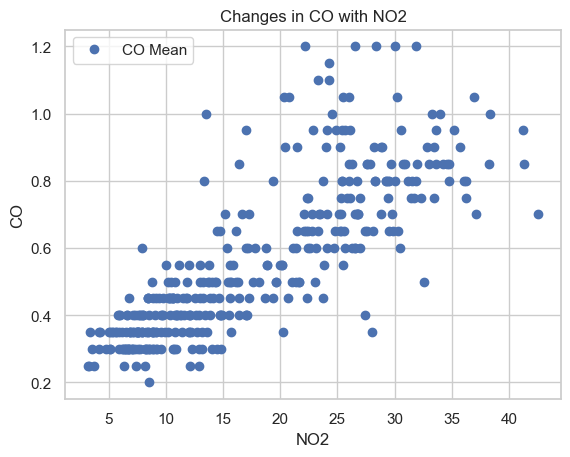

In [67]:
sd_mean_chemical_composition_df.plot(x='NO2 Mean', y='CO Mean', style='o', c='b')
plt.title('Changes in CO with NO2')  
plt.xlabel('NO2')  
plt.ylabel('CO')  
plt.show()

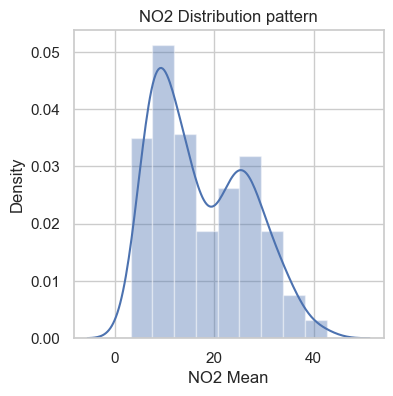

In [68]:
plt.figure(figsize=(4,4))
sb.distplot(sd_mean_chemical_composition_df['NO2 Mean'], color = 'b')
plt.title('NO2 Distribution pattern')
plt.show()

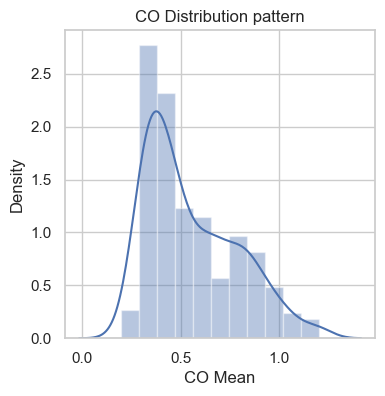

In [69]:
plt.figure(figsize=(4,4))
sb.distplot(sd_mean_chemical_composition_df['CO Mean'], color = 'b')
plt.title('CO Distribution pattern')
plt.show()

In [70]:
## Linear Model to study NO2 and CO relationship

In [71]:
x = sd_mean_chemical_composition_df['NO2 Mean'].values.reshape(-1,1)
y = sd_mean_chemical_composition_df['CO Mean'].values.reshape(-1,1)

In [72]:
x_train, x_test, y_train, y_test = skl_ms.train_test_split(x, y, test_size=0.2, random_state=0)

In [73]:
regressor = skl_lm.LinearRegression()  
regressor.fit(x_train, y_train)

LinearRegression()

In [74]:
print(regressor.intercept_)
print(regressor.coef_)

[0.21225655]
[[0.01984047]]


In [75]:
y_predicted = regressor.predict(x_test)

In [76]:
NO2_CO_df = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_predicted.flatten()})
NO2_CO_df.head()

,Actual,Predicted
0,0.35,0.614026
1,1.00,0.886833
2,0.60,0.661147
3,0.60,0.747949
4,0.35,0.523091


In [77]:
## Actual vs Predicted graph from the Model

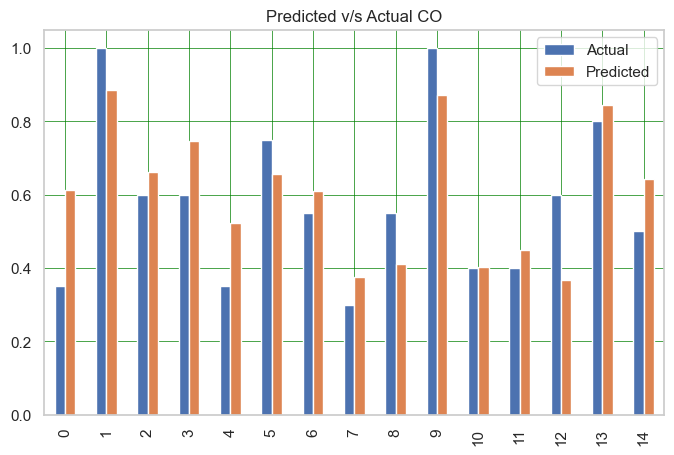

In [78]:
NO2_CO_df_part = NO2_CO_df.head(15)
NO2_CO_df_part.plot(kind='bar',figsize=(8,5))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.title('Predicted v/s Actual CO')
plt.show()

In [79]:
## Linear Regression Model Graph

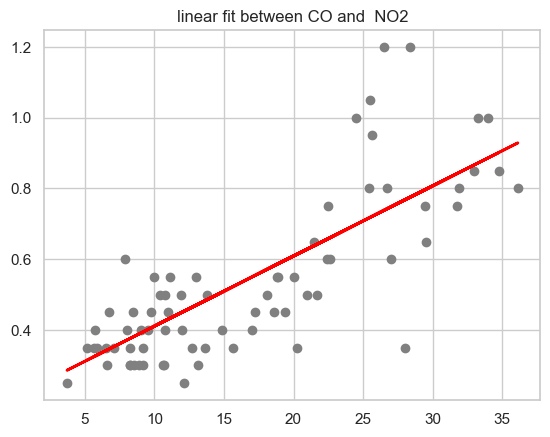

In [80]:
plt.scatter(x_test, y_test,  color='gray')
plt.plot(x_test, y_predicted, color='red', linewidth=2)
plt.title('linear fit between CO and  NO2')
plt.show()

In [81]:
print('Mean Absolute Error:', metr.mean_absolute_error(y_test, y_predicted))  
print('Mean Squared Error:', metr.mean_squared_error(y_test, y_predicted))  
print('Root Mean Squared Error:', np.sqrt(metr.mean_squared_error(y_test, y_predicted)))

Mean Absolute Error: 0.10610139947400861
Mean Squared Error: 0.0204797142155288
Root Mean Squared Error: 0.1431073520666524


In [82]:
sd_mean_chemical_composition_df.isnull().any()

Ozone Mean    False
CO Mean       False
NO2 Mean      False
PM2.5 Mean    False
dtype: bool

In [83]:
## Model to observe the formation of Ozone from the influence of NO2, CO and PM2.5

In [84]:
x = sd_mean_chemical_composition_df[[ 'NO2 Mean','CO Mean', 'PM2.5 Mean']].values
y = sd_mean_chemical_composition_df['Ozone Mean'].values

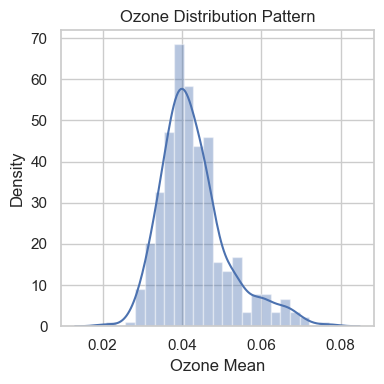

In [85]:
plt.figure(figsize=(4,4))
plt.title('Ozone Distribution Pattern')
sb.distplot(sd_mean_chemical_composition_df['Ozone Mean'])
plt.tight_layout()

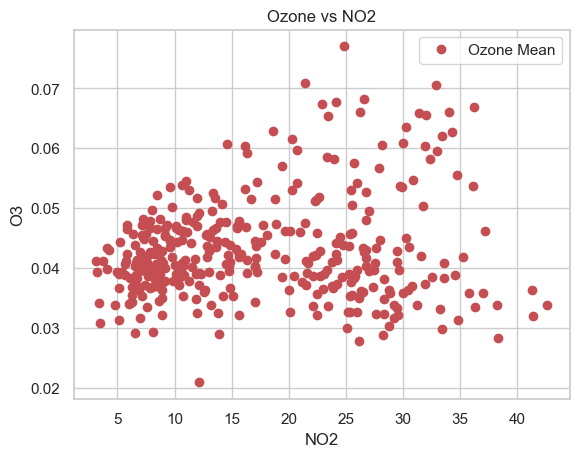

In [86]:
sd_mean_chemical_composition_df.plot(x='NO2 Mean', y='Ozone Mean', style='o', c='r')  
plt.title('Ozone vs NO2')  
plt.xlabel('NO2')  
plt.ylabel('O3')  
plt.show()

In [87]:
x_train, x_test, y_train, y_test = skl_ms.train_test_split(x, y, test_size=0.2, random_state=0)

In [88]:
model = skl_lm.LinearRegression()  
model.fit(x_train, y_train)

LinearRegression()

In [89]:
print(model.intercept_)
print(model.coef_)

0.036474719442005685
[ 0.00015711 -0.01051754  0.00078914]


In [90]:
y_predicted = model.predict(x_test)

In [91]:
Ozone_lm_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_predicted})
Ozone_lm_df.head()

,Actual,Predicted
0,0.053000,0.043093
1,0.066000,0.063049
2,0.051875,0.041910
3,0.039500,0.046375
4,0.042286,0.038245


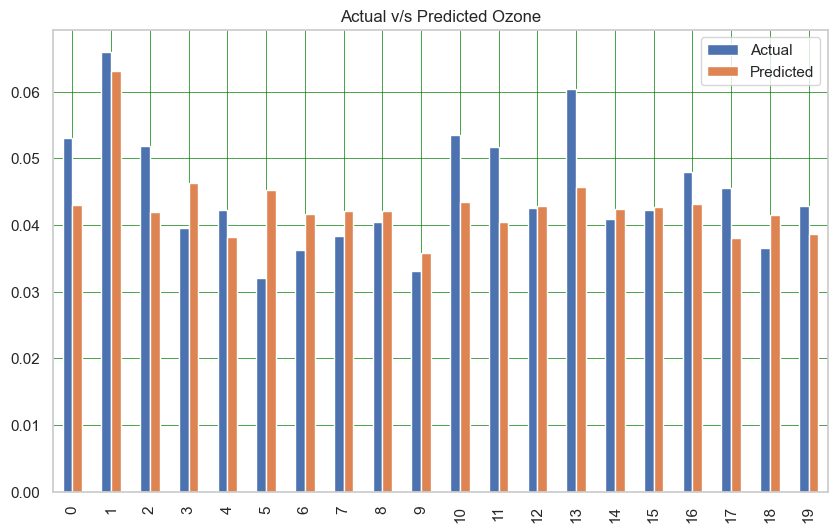

In [92]:
Ozone_lm_df_part = Ozone_lm_df.head(20)
Ozone_lm_df_part.plot(kind='bar',figsize=(10,6))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.title('Actual v/s Predicted Ozone')
plt.show()

In [93]:
print('Mean Absolute Error:', metr.mean_absolute_error(y_test, y_predicted))  
print('Mean Squared Error:', metr.mean_squared_error(y_test, y_predicted))  
print('Root Mean Squared Error:', np.sqrt(metr.mean_squared_error(y_test, y_predicted)))

Mean Absolute Error: 0.005033547539219841
Mean Squared Error: 4.251780785006544e-05
Root Mean Squared Error: 0.006520568061914962
